In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score


## Reading and Understanding the Data


In [3]:
df = pd.read_csv("day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


- Data Dictionary   
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [4]:
df.shape

(730, 16)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


Numeric values associated with the labels may indicate that there is some order to them. So,converting such feature values into categorical string values for better understanding 

In [6]:
def weekday(x):
    return x.map({1:'Mon', 2:'Tue', 3:'Wed', 4:'Thurs', 5:'Fri', 6:'Sat', 0:'Sun'})

df[['weekday']] = df[['weekday']].apply(weekday)

In [7]:
def month(x):
    return x.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})

df[['mnth']] = df[['mnth']].apply(month)

In [8]:
def season(x):
    return x.map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})

df[['season']] = df[['season']].apply(season)

In [9]:
def weathersit(x):
    return x.map({1:'Clear', 2:'Mist', 3:'Lightrain', 4:'Heavyrain'})

df[['weathersit']] = df[['weathersit']].apply(weathersit)

In [10]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,Spring,0,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,Spring,0,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,Spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,Spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,Spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Pre-processing

#### Missing value check

In [11]:
df.isnull().mean()

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

Hence we can conclude, there are no missing values in this dataset

#### Dropping columns 

- Since instant column is just the index it will not help us to draw insights
- dteday column can be explained by yr, mnth,so to avoid collinearity dropping this. 
- As per data dictionary cnt=registered+casual, since cnt is the target variable, dropping other two

In [12]:
df.drop(columns=['instant','dteday','registered','casual'],inplace= True)

In [13]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,Jan,0,Sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,Jan,0,Mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,Jan,0,Tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,Jan,0,Wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


### Segregating the data


In [14]:
df.nunique()

season          4
yr              2
mnth           12
holiday         2
weekday         7
workingday      2
weathersit      3
temp          498
atemp         689
hum           594
windspeed     649
cnt           695
dtype: int64

In [15]:
num_cols= ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
cat_cols=['season', 'yr', 'mnth', 'holiday', 'weekday','workingday', 'weathersit']

## Data Visualization

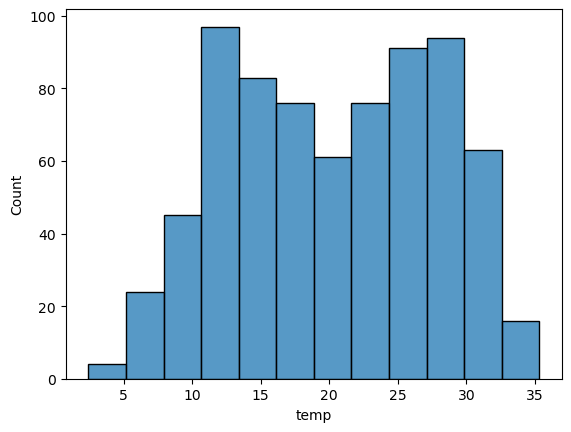

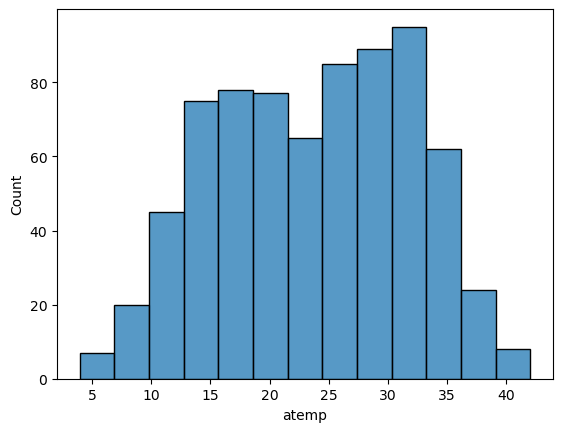

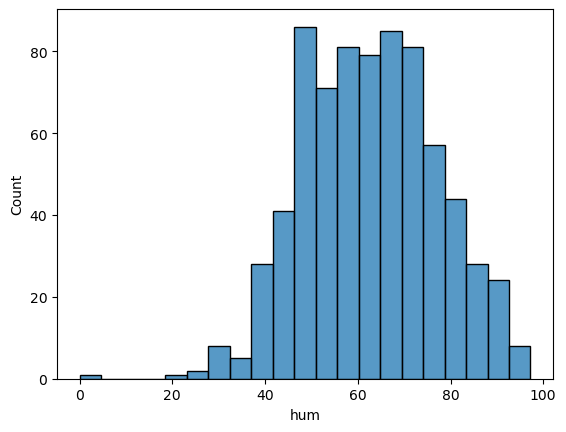

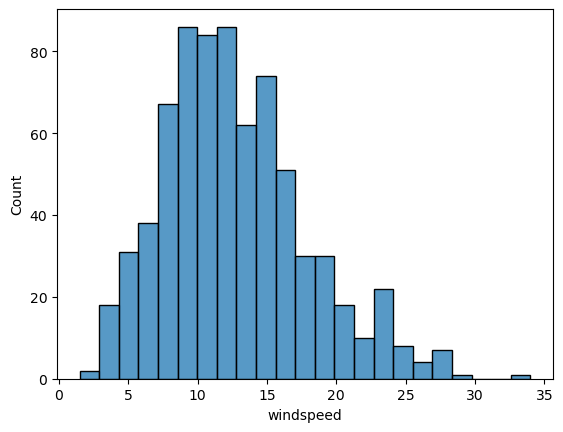

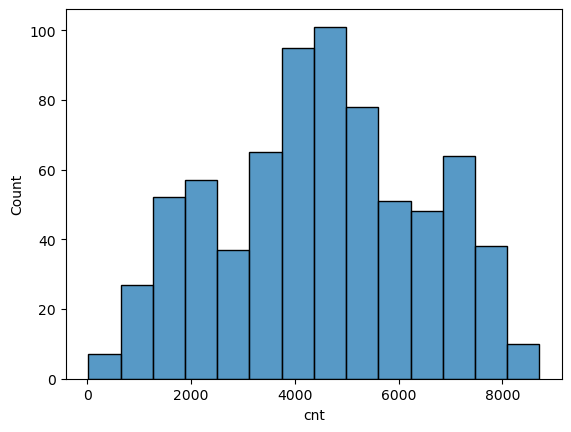

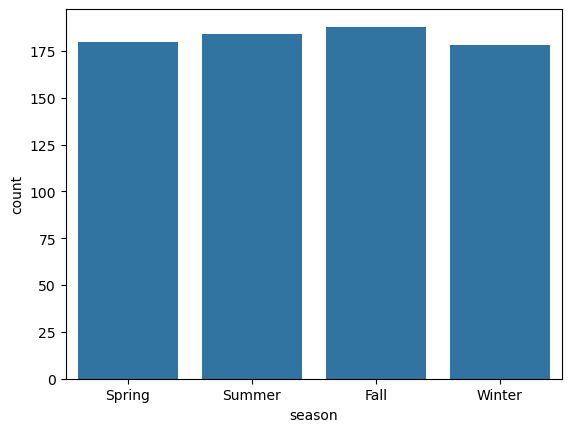

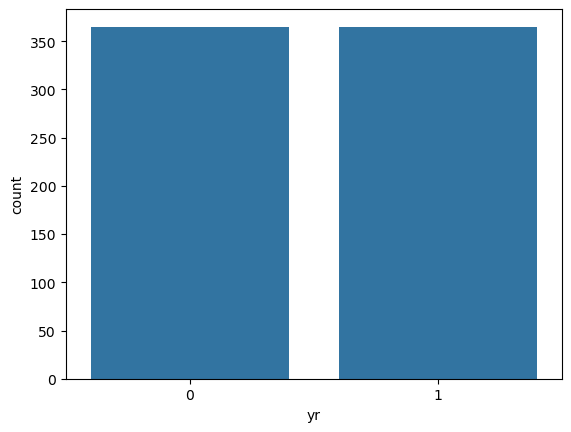

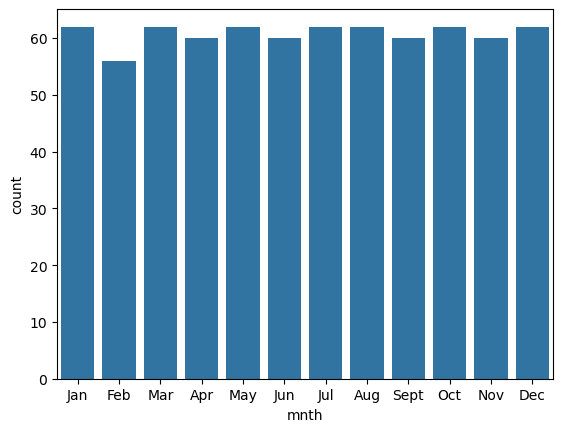

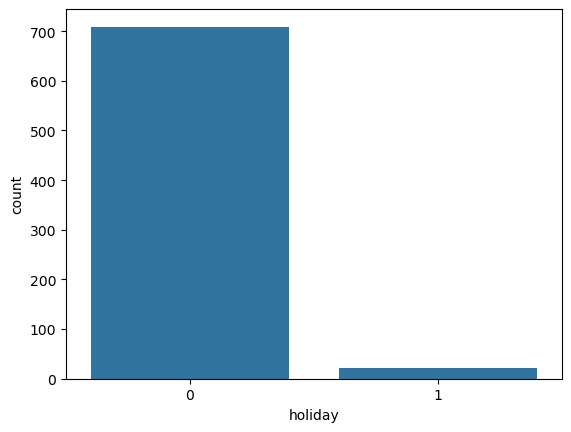

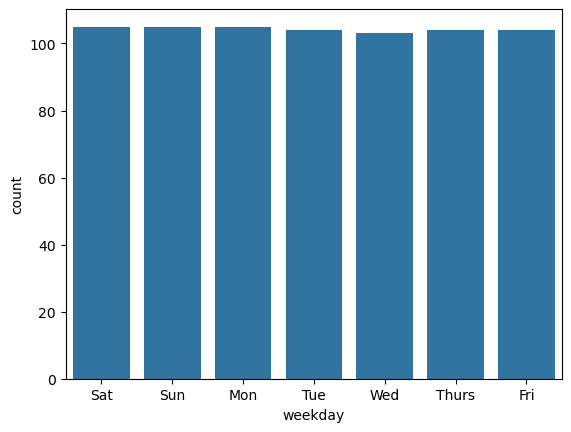

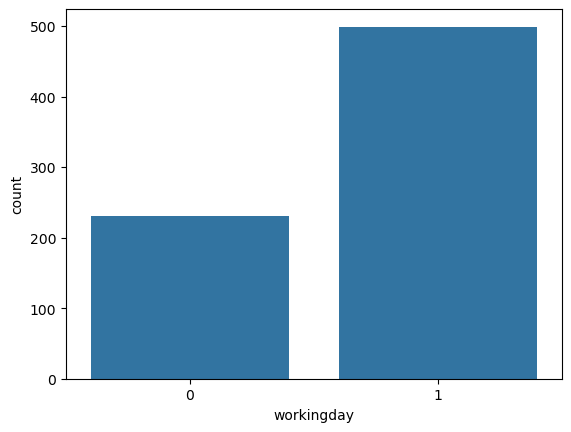

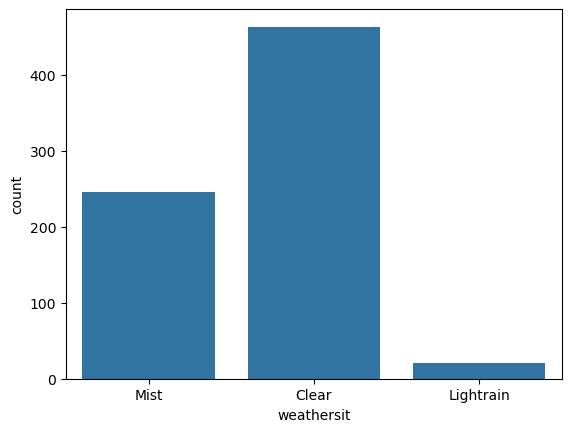

In [16]:
#Univariate Analysis
for i in num_cols:
    sns.histplot(x=df[i])
    plt.show()
for i in cat_cols:
    sns.countplot(x=df[i])
    plt.show()

#### We can concluded that there are no outliers in the dataset from univariate analysis

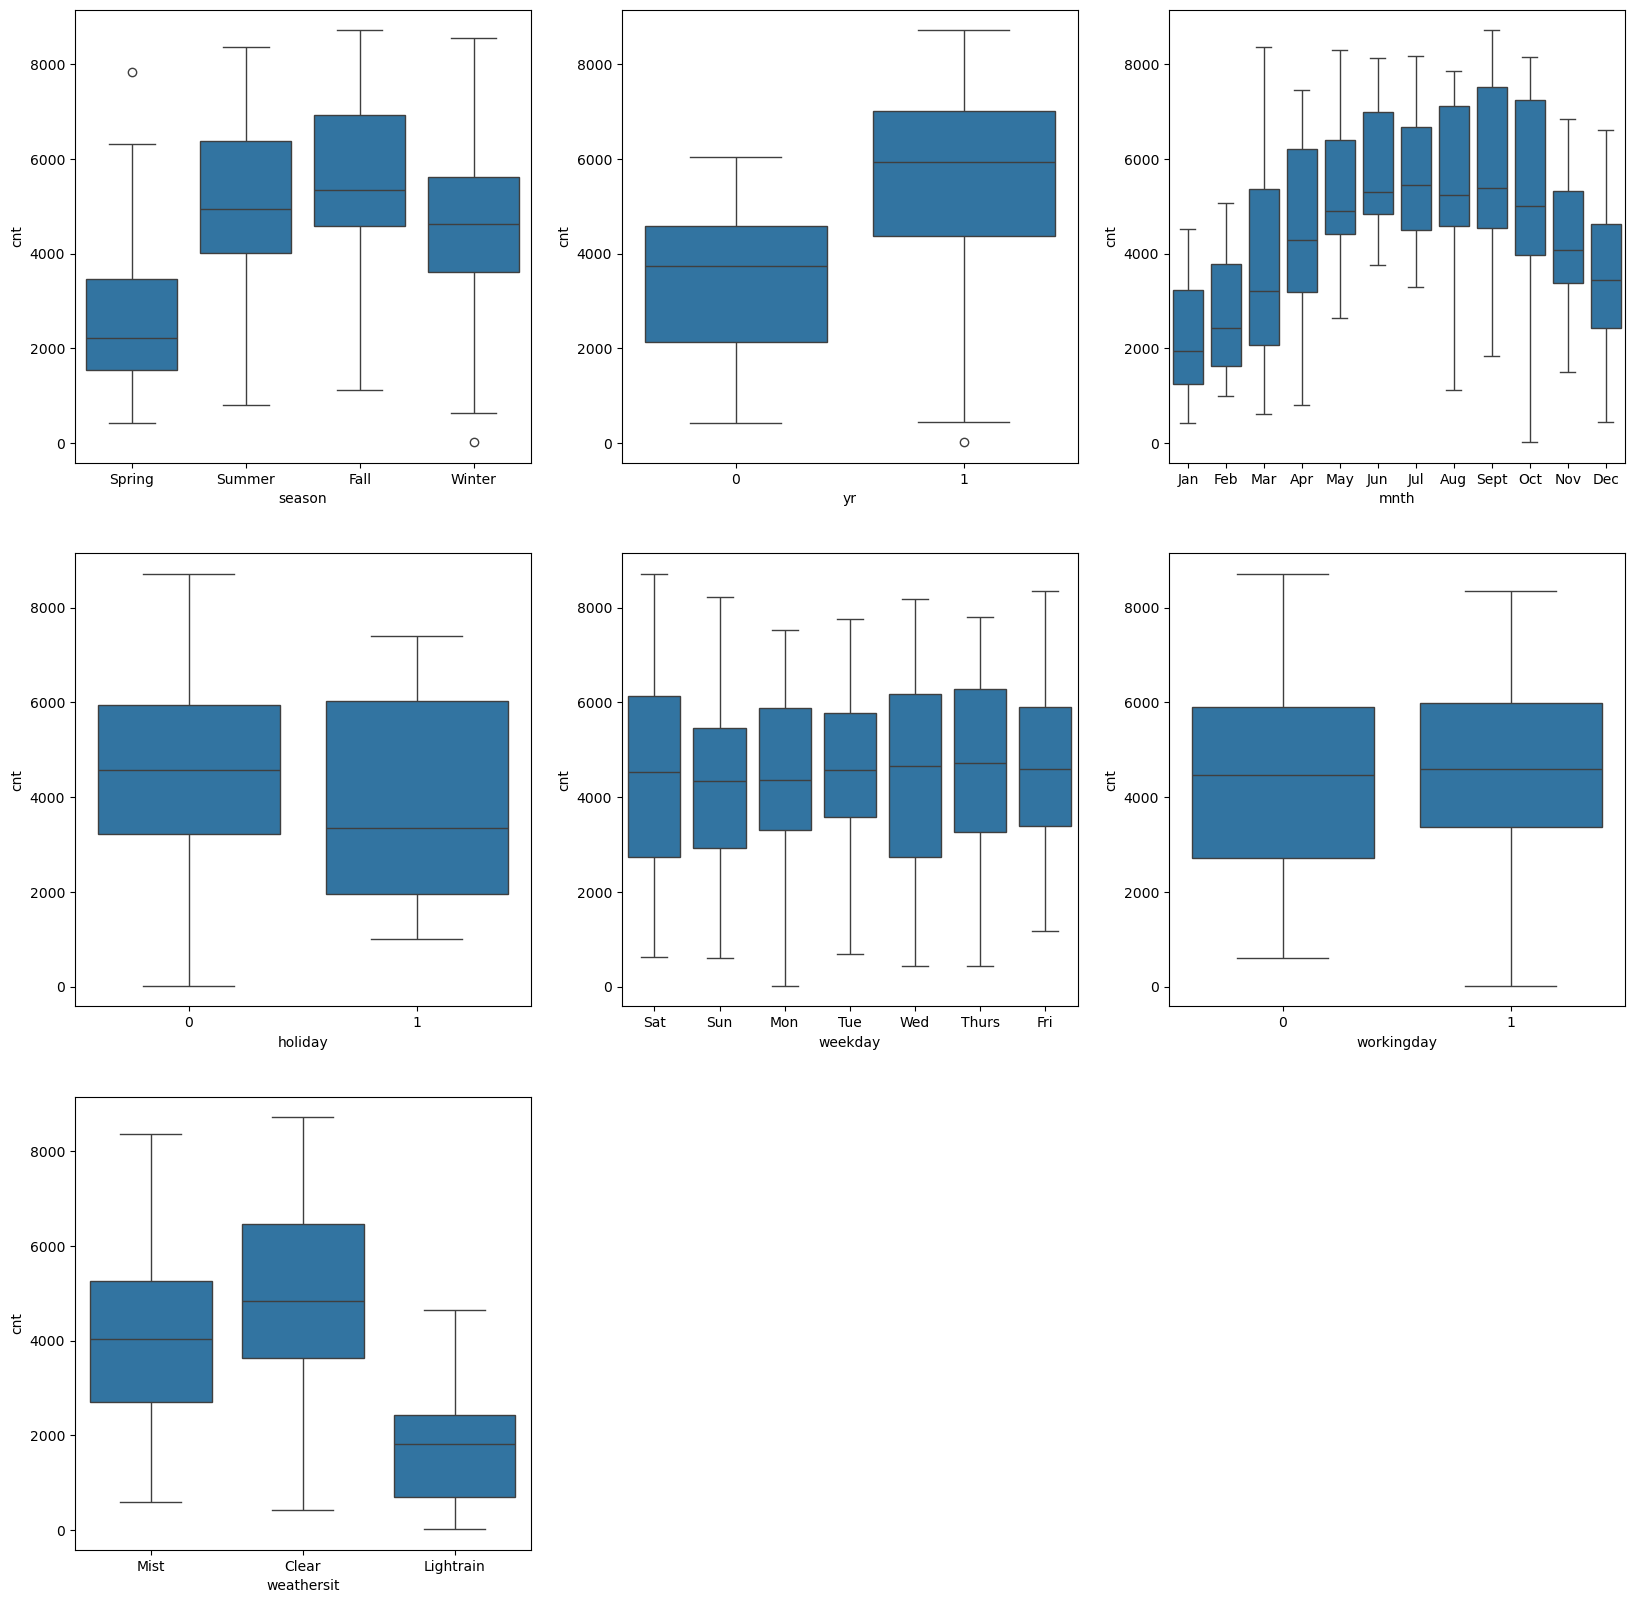

In [17]:
#Bivariate Analysis
plt.figure(figsize=(20, 20))
for i in range(1,8):
    plt.subplot(3,3,i)
    sns.boxplot(x= cat_cols[i-1], y = 'cnt', data=df)
plt.show()

#### holiday, weekday and working day do not seem to be good differentiators

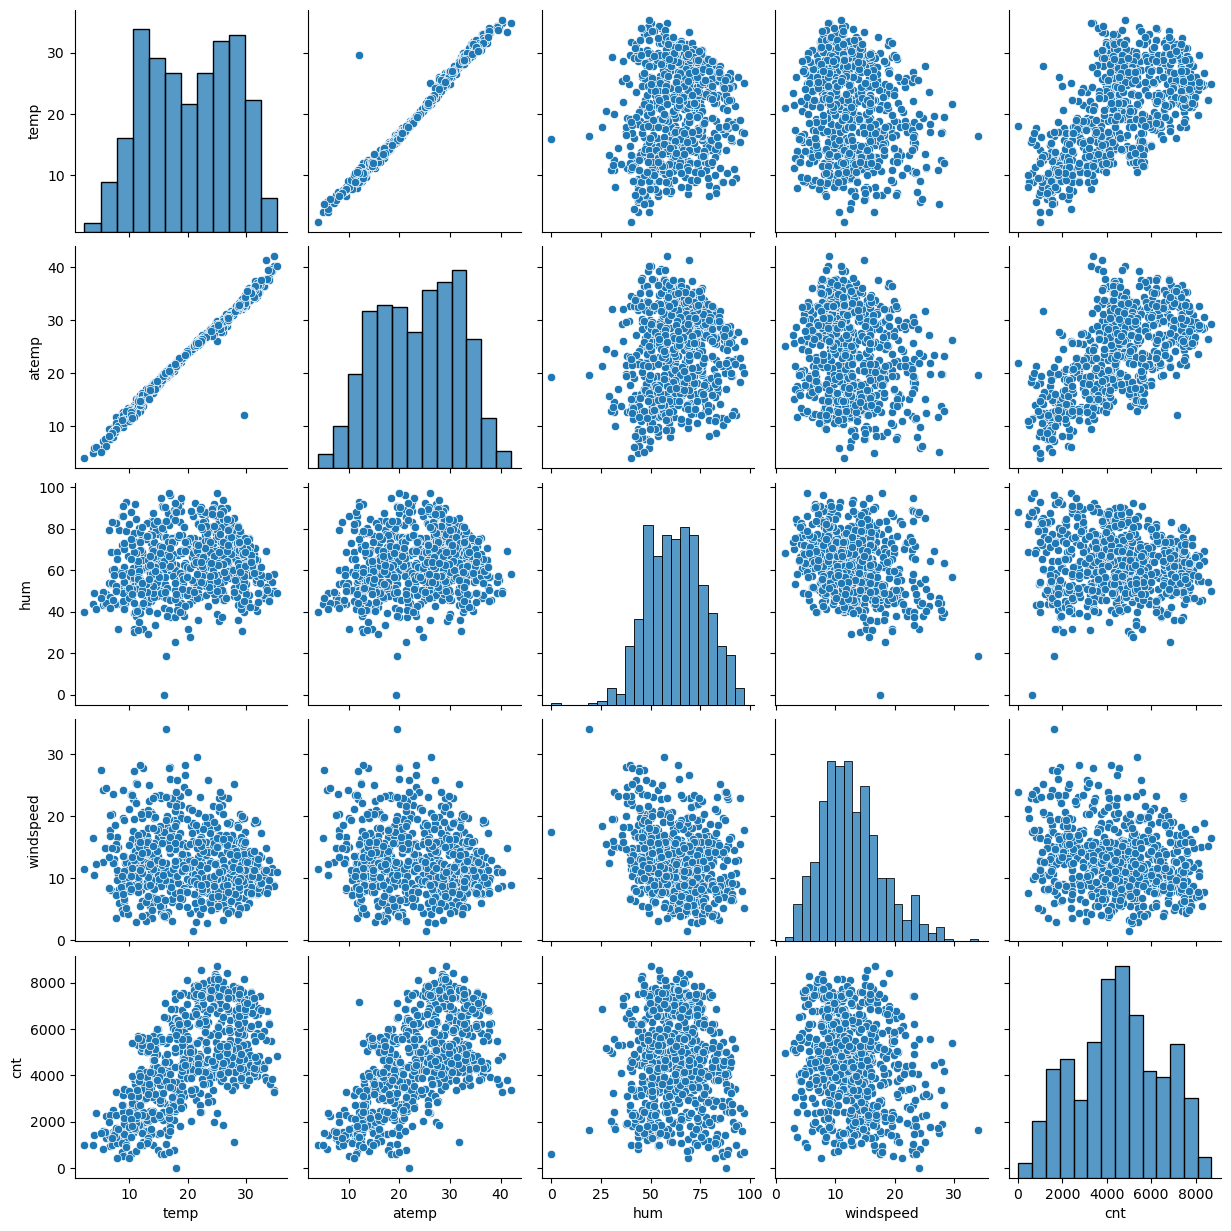

In [18]:
#Multivariate Analysis
sns.pairplot(df[num_cols])
plt.show()

<Axes: >

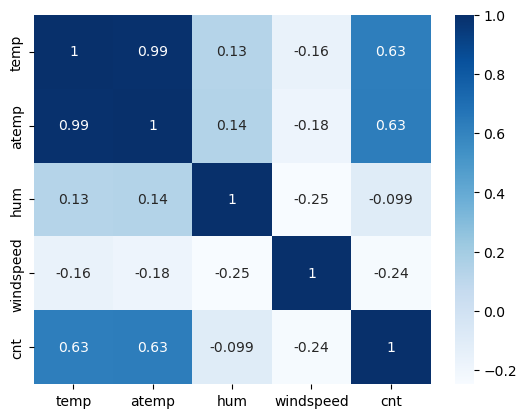

In [19]:
sns.heatmap(df[num_cols].corr(),cmap='Blues',annot=True)

#### temp and atemp have very high correlation, because of the assumptions independent variables must be non collinear in multi linear regression, we are dropping atemp, as temp is more business interpretable

In [20]:
df.drop(columns=['atemp'],inplace= True)
num_cols.remove('atemp')

## Data preparation- dummy variables

#### For categorical variable having two categories, we don't have to create dummy

In [21]:
df1=pd.get_dummies(df,columns=["season","mnth","weekday","weathersit"],drop_first=True,dtype=int) # n-1 dummy variables

In [22]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   yr                    730 non-null    int64  
 1   holiday               730 non-null    int64  
 2   workingday            730 non-null    int64  
 3   temp                  730 non-null    float64
 4   hum                   730 non-null    float64
 5   windspeed             730 non-null    float64
 6   cnt                   730 non-null    int64  
 7   season_Spring         730 non-null    int32  
 8   season_Summer         730 non-null    int32  
 9   season_Winter         730 non-null    int32  
 10  mnth_Aug              730 non-null    int32  
 11  mnth_Dec              730 non-null    int32  
 12  mnth_Feb              730 non-null    int32  
 13  mnth_Jan              730 non-null    int32  
 14  mnth_Jul              730 non-null    int32  
 15  mnth_Jun              7

## Train-Test split

In [23]:
X=df1.drop(["cnt"],axis=1)
y=df1["cnt"]

In [24]:
X.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_Spring', 'season_Summer', 'season_Winter', 'mnth_Aug',
       'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar',
       'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sept', 'weekday_Mon',
       'weekday_Sat', 'weekday_Sun', 'weekday_Thurs', 'weekday_Tue',
       'weekday_Wed', 'weathersit_Lightrain', 'weathersit_Mist'],
      dtype='object')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 300)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(584, 28)
(146, 28)
(584,)
(146,)


## Scaling 

In [27]:
num_cols.remove('cnt') # since cnt is a target variable

In [28]:
scaler=MinMaxScaler()
X_train[num_cols]=scaler.fit_transform(X_train[num_cols]) # fit and transform on training data
X_test[num_cols]=scaler.transform(X_test[num_cols]) # only transform on test data

In [29]:
X_train.describe()

,yr,holiday,workingday,temp,hum,windspeed,season_Spring,season_Summer,season_Winter,mnth_Aug,...,mnth_Oct,mnth_Sept,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thurs,weekday_Tue,weekday_Wed,weathersit_Lightrain,weathersit_Mist
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.494863,0.029110,0.690068,0.549259,0.642456,0.406530,0.243151,0.246575,0.248288,0.085616,...,0.080479,0.082192,0.147260,0.140411,0.140411,0.148973,0.143836,0.140411,0.027397,0.335616
std,0.500402,0.168258,0.462862,0.233986,0.146919,0.186346,0.429353,0.431387,0.432390,0.280037,...,0.272267,0.274892,0.354669,0.347711,0.347711,0.356367,0.351224,0.347711,0.163378,0.472610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.350768,0.529456,0.268155,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.549072,0.641816,0.386269,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.754230,0.749143,0.510744,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Now all values are rescaled between 0 and 1

## Modelling

### Automated Feature Selection-RFE

In [30]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm,n_features_to_select=15)            
rfe = rfe.fit(X_train, y_train)

In [31]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', False, 4),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', False, 9),
 ('season_Winter', True, 1),
 ('mnth_Aug', False, 8),
 ('mnth_Dec', True, 1),
 ('mnth_Feb', False, 5),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 11),
 ('mnth_Mar', False, 13),
 ('mnth_May', False, 2),
 ('mnth_Nov', True, 1),
 ('mnth_Oct', False, 3),
 ('mnth_Sept', True, 1),
 ('weekday_Mon', False, 7),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', False, 6),
 ('weekday_Thurs', False, 12),
 ('weekday_Tue', False, 10),
 ('weekday_Wed', False, 14),
 ('weathersit_Lightrain', True, 1),
 ('weathersit_Mist', True, 1)]

In [32]:
selected = X_train.columns[rfe.support_]
selected

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'season_Spring',
       'season_Winter', 'mnth_Dec', 'mnth_Jan', 'mnth_Jul', 'mnth_Nov',
       'mnth_Sept', 'weekday_Sat', 'weathersit_Lightrain', 'weathersit_Mist'],
      dtype='object')

In [33]:
rejected = X_train.columns[~rfe.support_]
rejected

Index(['holiday', 'season_Summer', 'mnth_Aug', 'mnth_Feb', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Oct', 'weekday_Mon', 'weekday_Sun',
       'weekday_Thurs', 'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [34]:
X_train=X_train[selected]
X_test=X_test[selected]

### Manual Feature Selection

In [35]:
X_train_sm=sm.add_constant(X_train)

In [36]:
model1=sm.OLS(y_train,X_train_sm)
res1=model1.fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     210.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.77e-220
Time:                        02:16:23   Log-Likelihood:                -4696.5
No. Observations:                 584   AIC:                             9425.
Df Residuals:                     568   BIC:                             9495.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 3053.4465    265.372     11.506      0.000    2532.217    3574.676
yr                    2039.3232     64.322     31.705      0.000    1912.984    2165.662
workingday             412.5527     86.535      4.767      0.000     242.586     582.520
temp                  3369.2028    258.440     13.037      0.000    2861.589    3876.817
hum                  -1335.9658    301.357     -4.433      0.000   -1927.877    -744.055
windspeed            -1131.6131    184.683     -6.127      0.000   -1494.358    -768.868
season_Spring        -1123.1622    125.693     -8.936      0.000   -1370.041    -876.283
season_Winter          673.1499    111.094      6.059      0.000     454.945     891.355
mnth_Dec              -581.5846    132.753     -4.381      0.000    -842.330    -320.839
mnth_Jan              -329.8046    140.539     -2.347      0.019    -605.844     -53.766
mnth_Jul              -551.5492    132.118     -4.175      0.000    -811.048    -292.050
mnth_Nov              -702.2699    148.239     -4.737      0.000    -993.434    -411.106
mnth_Sept              494.4630    121.907      4.056      0.000     255.020     733.906
weekday_Sat            528.9887    114.271      4.629      0.000     304.543     753.435
weathersit_Lightrain -1973.4277    218.723     -9.022      0.000   -2403.032   -1543.823
weathersit_Mist       -482.4128     85.539     -5.640      0.000    -650.424    -314.402
==============================================================================
Omnibus:                       83.259   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.841
Skew:                          -0.790   Prob(JB):                     1.46e-39
Kurtosis:                       5.202   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,24.79
2,temp,18.43
4,windspeed,5.21
1,workingday,4.77
5,season_Spring,3.16
6,season_Winter,2.93
14,weathersit_Mist,2.27
0,yr,2.01
10,mnth_Nov,1.84
12,weekday_Sat,1.74


#### We will remove hum feature because it has high vif

In [38]:
X_train_sm=X_train_sm.drop(['hum'],axis=1)

In [39]:
model2=sm.OLS(y_train,X_train_sm)
res2=model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     216.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.79e-217
Time:                        02:16:23   Log-Likelihood:                -4706.4
No. Observations:                 584   AIC:                             9443.
Df Residuals:                     569   BIC:                             9508.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2334.0237    213.382     10.938      0.000    1914.912    2753.136
yr                    2081.6775     64.643     32.203      0.000    1954.709    2208.646
workingday             445.1787     87.623      5.081      0.000     273.075     617.282
temp                  3087.3272    254.569     12.128      0.000    2587.318    3587.336
windspeed             -908.5384    180.585     -5.031      0.000   -1263.232    -553.845
season_Spring        -1155.8840    127.516     -9.065      0.000   -1406.343    -905.425
season_Winter          601.8881    111.712      5.388      0.000     382.470     821.306
mnth_Dec              -632.2357    134.410     -4.704      0.000    -896.237    -368.235
mnth_Jan              -372.6606    142.485     -2.615      0.009    -652.522     -92.799
mnth_Jul              -489.2485    133.504     -3.665      0.000    -751.469    -227.028
mnth_Nov              -716.5147    150.614     -4.757      0.000   -1012.342    -420.687
mnth_Sept              440.2547    123.264      3.572      0.000     198.147     682.363
weekday_Sat            550.8092    116.021      4.747      0.000     322.927     778.692
weathersit_Lightrain -2376.8261    202.130    -11.759      0.000   -2773.837   -1979.815
weathersit_Mist       -708.5487     69.781    -10.154      0.000    -845.609    -571.488
==============================================================================
Omnibus:                       81.175   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.581
Skew:                          -0.770   Prob(JB):                     7.47e-39
Kurtosis:                       5.201   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
vif = pd.DataFrame()
X_train=X_train.drop(['hum'],axis=1)
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,7.36
3,windspeed,5.21
1,workingday,4.71
4,season_Spring,2.54
5,season_Winter,2.54
0,yr,2.00
9,mnth_Nov,1.80
11,weekday_Sat,1.72
7,mnth_Jan,1.64
13,weathersit_Mist,1.56


#### Removing temp as it has high vif

In [41]:
X_train_sm1=X_train_sm.drop(['temp'],axis=1)

In [42]:
model3=sm.OLS(y_train,X_train_sm1)
res3=model3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     176.7
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          3.90e-190
Time:                        02:16:24   Log-Likelihood:                -4773.6
No. Observations:                 584   AIC:                             9575.
Df Residuals:                     570   BIC:                             9636.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 4455.8496    136.916     32.544      0.000    4186.929    4724.770
yr                    2148.6702     72.190     29.764      0.000    2006.880    2290.460
workingday             488.2458     98.131      4.975      0.000     295.504     680.987
windspeed            -1115.7445    201.498     -5.537      0.000   -1511.515    -719.974
season_Spring        -2113.8724    112.199    -18.840      0.000   -2334.247   -1893.498
season_Winter          171.1283    118.714      1.442      0.150     -62.042     404.298
mnth_Dec             -1065.4495    145.235     -7.336      0.000   -1350.710    -780.189
mnth_Jan              -793.8943    154.886     -5.126      0.000   -1098.110    -489.678
mnth_Jul               143.9236    137.720      1.045      0.296    -126.577     414.424
mnth_Nov             -1174.9261    163.412     -7.190      0.000   -1495.889    -853.964
mnth_Sept              637.2168    136.955      4.653      0.000     368.219     906.214
weekday_Sat            543.5022    130.040      4.180      0.000     288.087     798.918
weathersit_Lightrain -2453.7314    226.443    -10.836      0.000   -2898.496   -2008.966
weathersit_Mist       -758.4511     78.077     -9.714      0.000    -911.806    -605.096
==============================================================================
Omnibus:                       58.221   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.403
Skew:                          -0.664   Prob(JB):                     1.92e-21
Kurtosis:                       4.469   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Removing temp has reduced the adjusted R square value significantly hence we will not remove

#### Removing mnth_Jan as it has some p-value

In [43]:
X_train_sm=X_train_sm.drop(['mnth_Jan'],axis=1)

In [44]:
model3=sm.OLS(y_train,X_train_sm)
res3=model3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     230.4
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.32e-217
Time:                        02:16:24   Log-Likelihood:                -4709.9
No. Observations:                 584   AIC:                             9448.
Df Residuals:                     570   BIC:                             9509.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2210.6112    209.163     10.569      0.000    1799.788    2621.435
yr                    2075.1913     64.926     31.963      0.000    1947.669    2202.714
workingday             448.1739     88.063      5.089      0.000     275.206     621.142
temp                  3249.6290    248.151     13.095      0.000    2762.227    3737.031
windspeed             -878.7930    181.147     -4.851      0.000   -1234.590    -522.996
season_Spring        -1238.9755    124.126     -9.982      0.000   -1482.775    -995.176
season_Winter          603.1732    112.282      5.372      0.000     382.637     823.710
mnth_Dec              -548.2453    131.185     -4.179      0.000    -805.910    -290.581
mnth_Jul              -519.6564    133.676     -3.887      0.000    -782.215    -257.098
mnth_Nov              -669.2989    150.292     -4.453      0.000    -964.493    -374.104
mnth_Sept              438.2885    123.892      3.538      0.000     194.949     681.628
weekday_Sat            552.1426    116.613      4.735      0.000     323.099     781.187
weathersit_Lightrain -2368.8532    203.139    -11.661      0.000   -2767.846   -1969.860
weathersit_Mist       -704.5190     70.121    -10.047      0.000    -842.246    -566.792
==============================================================================
Omnibus:                       77.287   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.820
Skew:                          -0.748   Prob(JB):                     7.27e-36
Kurtosis:                       5.101   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
vif = pd.DataFrame()
X_train=X_train.drop(['mnth_Jan'],axis=1)
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,7.26
3,windspeed,5.20
1,workingday,4.69
5,season_Winter,2.52
0,yr,1.99
4,season_Spring,1.96
8,mnth_Nov,1.79
10,weekday_Sat,1.71
12,weathersit_Mist,1.56
6,mnth_Dec,1.45


#### Removing workingday as it has next high vif

In [46]:
X_train_sm=X_train_sm.drop(['workingday'],axis=1)

In [47]:
model4=sm.OLS(y_train,X_train_sm)
res4=model4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     237.1
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.02e-212
Time:                        02:16:25   Log-Likelihood:                -4722.9
No. Observations:                 584   AIC:                             9472.
Df Residuals:                     571   BIC:                             9529.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2527.5684    203.982     12.391      0.000    2126.921    2928.216
yr                    2067.5659     66.309     31.181      0.000    1937.328    2197.804
temp                  3306.5568    253.246     13.057      0.000    2809.149    3803.965
windspeed             -866.0010    185.037     -4.680      0.000   -1229.437    -502.565
season_Spring        -1238.0885    126.803     -9.764      0.000   -1487.146    -989.031
season_Winter          604.0943    114.704      5.267      0.000     378.802     829.387
mnth_Dec              -536.5966    133.994     -4.005      0.000    -799.778    -273.415
mnth_Jul              -536.0026    136.521     -3.926      0.000    -804.146    -267.859
mnth_Nov              -675.5454    153.529     -4.400      0.000    -977.097    -373.994
mnth_Sept              415.8308    126.484      3.288      0.001     167.401     664.261
weekday_Sat            194.4360     95.058      2.045      0.041       7.731     381.141
weathersit_Lightrain -2306.7447    207.147    -11.136      0.000   -2713.607   -1899.883
weathersit_Mist       -673.4673     71.362     -9.437      0.000    -813.631    -533.304
==============================================================================
Omnibus:                       87.249   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              169.886
Skew:                          -0.861   Prob(JB):                     1.29e-37
Kurtosis:                       5.004   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
vif = pd.DataFrame()
X_train=X_train.drop(['workingday'],axis=1)
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,5.37
2,windspeed,5.07
4,season_Winter,2.47
0,yr,1.99
3,season_Spring,1.80
7,mnth_Nov,1.79
11,weathersit_Mist,1.53
5,mnth_Dec,1.44
6,mnth_Jul,1.43
8,mnth_Sept,1.21


#### removing weekday_Sat as it as high p-value

In [49]:
X_train_sm=X_train_sm.drop(['weekday_Sat'],axis=1)

In [50]:
model5=sm.OLS(y_train,X_train_sm)
res5=model5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     256.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          4.96e-213
Time:                        02:16:25   Log-Likelihood:                -4725.0
No. Observations:                 584   AIC:                             9474.
Df Residuals:                     572   BIC:                             9526.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2573.3709    203.313     12.657      0.000    2174.040    2972.702
yr                    2064.4372     66.475     31.056      0.000    1933.872    2195.002
temp                  3286.1392    253.753     12.950      0.000    2787.738    3784.540
windspeed             -865.6505    185.551     -4.665      0.000   -1230.095    -501.206
season_Spring        -1249.5827    127.031     -9.837      0.000   -1499.086   -1000.079
season_Winter          600.0033    115.005      5.217      0.000     374.120     825.887
mnth_Dec              -534.7269    134.363     -3.980      0.000    -798.633    -270.821
mnth_Jul              -537.9043    136.897     -3.929      0.000    -806.786    -269.022
mnth_Nov              -678.6345    153.949     -4.408      0.000    -981.008    -376.261
mnth_Sept              421.9061    126.800      3.327      0.001     172.855     670.957
weathersit_Lightrain -2313.7535    207.694    -11.140      0.000   -2721.689   -1905.818
weathersit_Mist       -679.7851     71.493     -9.508      0.000    -820.206    -539.364
==============================================================================
Omnibus:                       80.876   Durbin-Watson:                   2.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              155.064
Skew:                          -0.811   Prob(JB):                     2.13e-34
Kurtosis:                       4.934   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif = pd.DataFrame()
X_train=X_train.drop(['weekday_Sat'],axis=1)
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,5.30
2,windspeed,5.05
4,season_Winter,2.47
0,yr,1.99
3,season_Spring,1.79
7,mnth_Nov,1.79
10,weathersit_Mist,1.53
5,mnth_Dec,1.44
6,mnth_Jul,1.42
8,mnth_Sept,1.21


#### removing mnth_Sept as it as high p-value

In [52]:
X_train_sm=X_train_sm.drop(['mnth_Sept'],axis=1)

In [53]:
model6=sm.OLS(y_train,X_train_sm)
res6=model6.fit()
res6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     276.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          6.86e-212
Time:                        02:16:25   Log-Likelihood:                -4730.6
No. Observations:                 584   AIC:                             9483.
Df Residuals:                     573   BIC:                             9531.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2574.1528    205.092     12.551      0.000    2171.329    2976.976
yr                    2061.8790     67.052     30.750      0.000    1930.181    2193.577
temp                  3397.7163    253.728     13.391      0.000    2899.366    3896.067
windspeed             -911.4594    186.659     -4.883      0.000   -1278.078    -544.841
season_Spring        -1258.5259    128.114     -9.824      0.000   -1510.155   -1006.896
season_Winter          629.8371    115.658      5.446      0.000     402.671     857.003
mnth_Dec              -575.5309    134.973     -4.264      0.000    -840.634    -310.428
mnth_Jul              -622.0528    135.718     -4.583      0.000    -888.618    -355.488
mnth_Nov              -735.3087    154.342     -4.764      0.000   -1038.454    -432.163
weathersit_Lightrain -2305.6374    209.497    -11.006      0.000   -2717.112   -1894.162
weathersit_Mist       -671.4306     72.074     -9.316      0.000    -812.992    -529.869
==============================================================================
Omnibus:                       76.245   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.451
Skew:                          -0.769   Prob(JB):                     1.58e-32
Kurtosis:                       4.911   Cond. No.                         14.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
vif = pd.DataFrame()
X_train=X_train.drop(['mnth_Sept'],axis=1)
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,5.02
1,temp,4.93
4,season_Winter,2.45
0,yr,1.99
3,season_Spring,1.79
7,mnth_Nov,1.77
9,weathersit_Mist,1.53
5,mnth_Dec,1.43
6,mnth_Jul,1.37
8,weathersit_Lightrain,1.08


#### Since the VIFs and p-values both are within an acceptable range. So we go ahead and make our predictions using this model.

In [55]:
removed_cols= ['hum', 'mnth_Jan', 'workingday', 'weekday_Sat', 'mnth_Sept']

## Residual Analysis

In [56]:
y_train_pred = res6.predict(X_train_sm)

<Axes: ylabel='Density'>

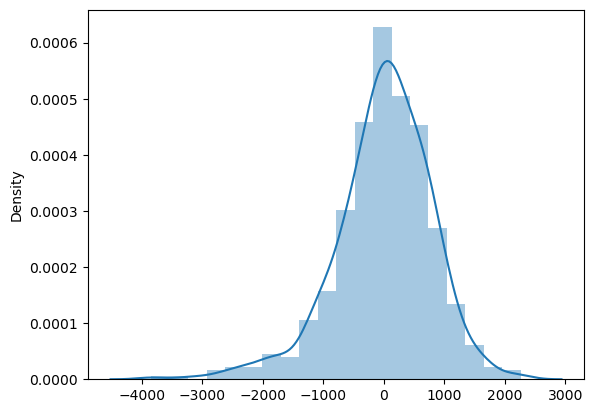

In [57]:
sns.distplot((y_train - y_train_pred), bins = 20)                     

#### Error terms are normally distributed with mean at 0

<Axes: >

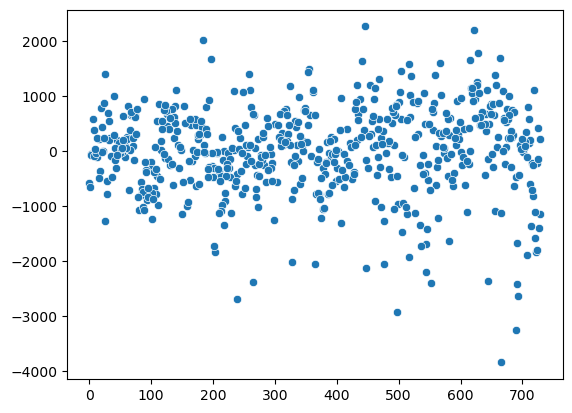

In [58]:
sns.scatterplot((y_train - y_train_pred))                     

#### Error terms are independent of each other

## Predictions and Model Evaluation

In [59]:
X_test_sm = sm.add_constant(X_test)

In [60]:
X_test_sm = X_test_sm.drop(removed_cols, axis = 1)

In [61]:
y_pred = res6.predict(X_test_sm)

In [62]:
# test data r2 score
r2_score(y_train, y_train_pred)

0.828386567323328

In [63]:
## train data r2 score
r2_score(y_test, y_pred)

0.8146135917605993

<Axes: xlabel='cnt'>

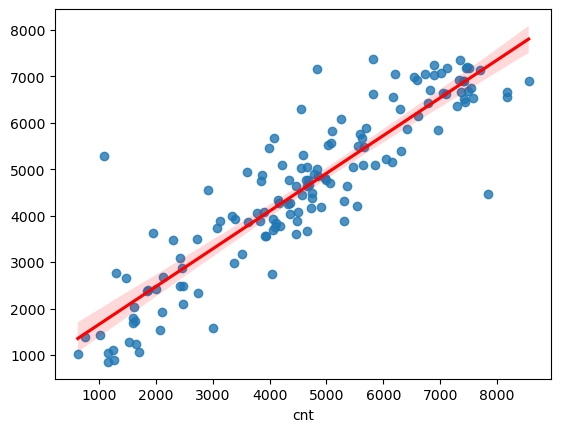

In [64]:
sns.regplot(x = y_test,y = y_pred, line_kws={'color':'red'})

## Interpretation

1. approximately 82% of the variance in data is explained by the following features -

    - windspeed
    - temp
    - season_Winter
    - yr
    - season_Spring
    - mnth_Nov
    - weathersit_Mist
    - mnth_Dec
    - mnth_Jul
    - weathersit_Lightrain

2. All the selected variables are significant as their p-value is 0.

3. p(F-statistic) is very low, which means that the overall model fit is significant, and not by chance.

4. The model generalizes well on both train and test data, as R2-score of both is approximately equal.

5. Since VIF of all predictor variables is less than equal to 5, there is no multi-collinearity.

Best fit line-

$ cnt = 2061.88 \times  yr + 3397.72 \times  temp - 911.46 \times windspeed - 1258.53 \times season\_Spring + 629.84 \times season\_Winter - 575.53 \times mnth\_Dec - 622.05 \times mnth\_Jul - 735.31 \times mnth\_Nov - 2305.64 \times weathersit\_Lightrain - 671.43 \times weathersit\_Mist $